# Comparison to the literature of Galaxy Builder bulges and bars

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
from os.path import join
from tqdm import tqdm
import scipy.stats as st
import json
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as pa
import gzbuilder_analysis.fitting as fg

In [3]:
# %run make_bulge_bar_dataframes.py

In [4]:
def number_with_comp(a):
    return sum(i is not None for i in a)

def clean_column_names(df):
    df_ = df.copy()
    df_.columns = [i.strip().replace(' ', '_') for i in df.columns]
    return df_

def get_pbar(gal):
    n = gal['t03_bar_a06_bar_debiased'] + gal['t03_bar_a07_no_bar_debiased']
    return gal['t03_bar_a06_bar_debiased'] / n


In [5]:
agg_res_path = 'output_files/aggregation_results'
agg_results = pd.Series([], dtype=object)
with tqdm(os.listdir(agg_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pkl.gz', f):
                agg_results[int(f.split('.')[0])] = pd.read_pickle(
                    os.path.join(agg_res_path, f)
                )

100%|██████████| 296/296 [00:02<00:00, 98.95it/s] 


In [6]:
# load files contain info relating gzb subject ids to GZ2 bulge / bar results:
bulge_df = pd.read_pickle('lib/bulge_fractions.pkl').dropna()
bar_df = pd.read_pickle('lib/bar_fractions.pkl').dropna()

In [7]:
comparison_df = agg_results.agg(dict(
    cls=lambda a: len(a.input_models),
    disk=lambda a: a.input_models.apply(lambda a: bool(a['disk'])).sum(),
    bulge=lambda a: a.input_models.apply(lambda a: bool(a['bulge'])).sum(),
    bar=lambda a: a.input_models.apply(lambda a: bool(a['bar'])).sum(),
)).unstack().T

comparison_df = comparison_df.assign(
    disk_frac=comparison_df.disk / comparison_df.cls,
    bulge_frac=comparison_df.bulge / comparison_df.cls,
    bar_frac=comparison_df.bar / comparison_df.cls,
)

comparison_df = comparison_df.assign(
    disk_frac_err=np.sqrt(comparison_df.disk_frac * (1 - comparison_df.disk_frac) / comparison_df.cls),
    bulge_frac_err=np.sqrt(comparison_df.bulge_frac * (1 - comparison_df.bulge_frac) / comparison_df.cls),
    bar_frac_err=np.sqrt(comparison_df.bar_frac * (1 - comparison_df.bar_frac) / comparison_df.cls),
)

# Let's also incorporate knowledge about the aggregagte model (did we cluster a component)
comparison_df = comparison_df.combine_first(
    agg_results.apply(lambda a: a.model).apply(pd.Series).applymap(bool).add_prefix('agg_')
)

# and finaly add in information about GZ2:
comparison_df = comparison_df.assign(
    GZ2_no_bulge=bulge_df['GZ2 no bulge'],
    GZ2_bar_fraction=bar_df['GZ2 bar fraction'],
).dropna().pipe(clean_column_names)

Let's also incorporate knowledge about the aggregagte model (did we cluster a component)

In [8]:
comparison_df.head()

,agg_bar,agg_bulge,agg_disk,agg_spiral,bar,bar_frac,bar_frac_err,bulge,bulge_frac,bulge_frac_err,cls,disk,disk_frac,disk_frac_err,GZ2_no_bulge,GZ2_bar_fraction
20902004,False,True,True,False,9,0.300000,0.083666,23,0.766667,0.077220,30,26,0.866667,0.062063,0.306266,0.063034
20902079,False,True,True,False,6,0.200000,0.073030,23,0.766667,0.077220,30,24,0.800000,0.073030,0.034202,0.308534
21686588,False,True,True,False,10,0.333333,0.086066,23,0.766667,0.077220,30,24,0.800000,0.073030,0.182000,0.212000
21686496,True,False,True,True,13,0.433333,0.090472,18,0.600000,0.089443,30,21,0.700000,0.083666,0.211000,0.263000
21096782,False,True,True,True,13,0.433333,0.090472,25,0.833333,0.068041,30,29,0.966667,0.032773,0.133785,0.080096


In [103]:
comparison_df.query('GZ2_bar_fraction < 0.2').bar_frac.describe()

count    139.000000
mean       0.288010
std        0.109677
min        0.066667
25%        0.200000
50%        0.266667
75%        0.366667
max        0.633333
Name: bar_frac, dtype: float64

In [104]:
comparison_df.query('GZ2_bar_fraction > 0.5').bar_frac.describe()

count    64.000000
mean      0.465104
std       0.148767
min       0.133333
25%       0.366667
50%       0.466667
75%       0.566667
max       0.733333
Name: bar_frac, dtype: float64

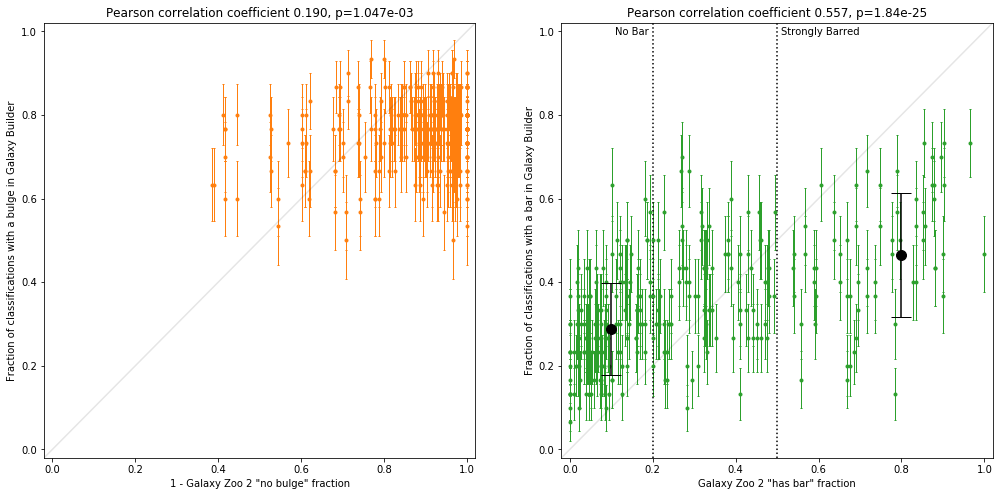

In [131]:
f, ax = plt.subplots(ncols=2, figsize=(17, 8))
plt.sca(ax[0])
plt.errorbar(
    1 - comparison_df['GZ2_no_bulge'],
    comparison_df['bulge_frac'], yerr=comparison_df['bulge_frac_err'],
    fmt='.', c='C1', elinewidth=1, capsize=1
)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.gca().add_line(plt.Line2D((-10, 10), (-10, 10), c='k', alpha=0.1))
plt.xlabel('1 - Galaxy Zoo 2 "no bulge" fraction')
plt.ylabel('Fraction of classifications with a bulge in Galaxy Builder')

gz2_no_bulge, gzb_bulge = comparison_df[['GZ2_no_bulge', 'bulge_frac']].dropna().values.T
bar_corr = st.pearsonr(1 - gz2_no_bulge, gzb_bulge)
plt.title('Pearson correlation coefficient {:.3f}, p={:.3e}'.format(*bar_corr));

plt.sca(ax[1])
plt.errorbar(
    comparison_df['GZ2_bar_fraction'], comparison_df['bar_frac'],
    yerr=comparison_df['bar_frac_err'],
    fmt='.', c='C2', elinewidth=1, capsize=1
)
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.axvline(0.2, c='k', ls=':')
plt.axvline(0.5, c='k', ls=':')
plt.errorbar(
    0.1,
    **comparison_df.query('GZ2_bar_fraction < 0.2').bar_frac.describe()
        .rename(index=dict(mean='y', std='yerr'))[['y', 'yerr']],
    zorder=10, fmt='o', capsize=10, color='k', ms=10
)
plt.errorbar(
    0.8,
    **comparison_df.query('GZ2_bar_fraction > 0.5').bar_frac.describe()
        .rename(index=dict(mean='y', std='yerr'))[['y', 'yerr']],
    zorder=10, fmt='o', capsize=10, color='k', ms=10
)
plt.text(0.2 - 0.01, 1.01, 'No Bar', horizontalalignment='right', verticalalignment='top')
plt.text(0.5 + 0.01, 1.01, 'Strongly Barred', horizontalalignment='left', verticalalignment='top')
plt.gca().add_line(plt.Line2D((-10, 10), (-10, 10), c='k', alpha=0.1))
plt.xlabel('Galaxy Zoo 2 "has bar" fraction')
plt.ylabel('Fraction of classifications with a bar in Galaxy Builder')
bar_corr = st.pearsonr(*comparison_df[['GZ2_bar_fraction', 'bar_frac']].dropna().values.T)
plt.title('Pearson correlation coefficient {:.3f}, p={:.2e}'.format(*bar_corr));

Let's add in some indormation about whether the aggregate model contained this component:

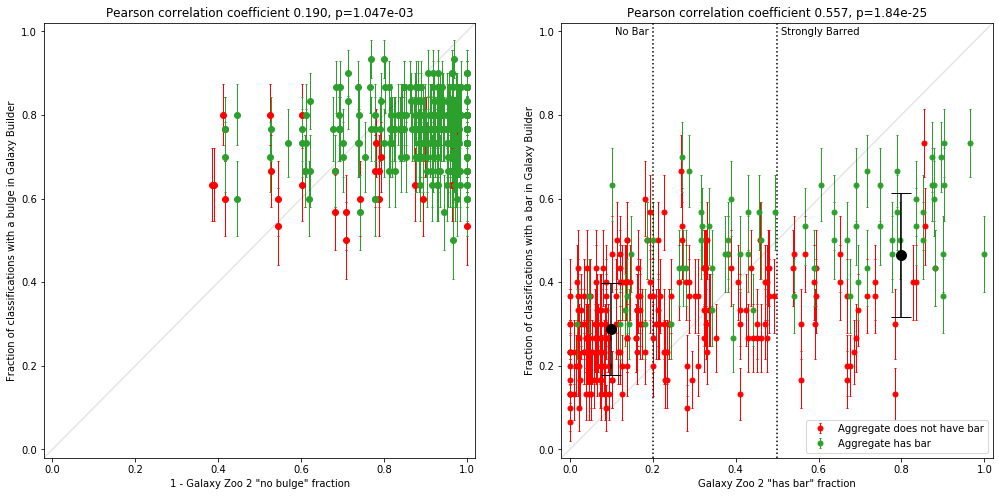

In [10]:
f, ax = plt.subplots(ncols=2, figsize=(17, 8))
plt.sca(ax[0])
for i in (False, True):
    mask = comparison_df.agg_bulge == i
    plt.errorbar(
        1 - comparison_df['GZ2_no_bulge'][mask],
        comparison_df['bulge_frac'][mask], yerr=comparison_df['bulge_frac_err'][mask],
        fmt='o', c=('C2' if i else 'r'), elinewidth=1, capsize=1,
        label=('Aggregate has bulge' if i else 'Aggregate does not have bulge')
    )
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.gca().add_line(plt.Line2D((-10, 10), (-10, 10), c='k', alpha=0.1))
plt.xlabel('1 - Galaxy Zoo 2 "no bulge" fraction')
plt.ylabel('Fraction of classifications with a bulge in Galaxy Builder')

gz2_no_bulge, gzb_bulge = comparison_df[['GZ2_no_bulge', 'bulge_frac']].dropna().values.T
bar_corr = st.pearsonr(1 - gz2_no_bulge, gzb_bulge)
plt.title('Pearson correlation coefficient {:.3f}, p={:.3e}'.format(*bar_corr));

plt.sca(ax[1])
for i in (False, True):
    mask = comparison_df.agg_bar == i
    plt.errorbar(
        comparison_df['GZ2_bar_fraction'][mask], comparison_df['bar_frac'][mask],
        yerr=comparison_df['bar_frac_err'][mask],
        fmt='o', c=('C2' if i else 'r'), ms=5, elinewidth=1, capsize=1,
        label=('Aggregate has bar' if i else 'Aggregate does not have bar')
    )
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.axvline(0.2, c='k', ls=':')
plt.axvline(0.5, c='k', ls=':')
plt.errorbar(
    0.1,
    **comparison_df.query('GZ2_bar_fraction < 0.2').bar_frac.describe()
        .rename(index=dict(mean='y', std='yerr'))[['y', 'yerr']],
    zorder=10, fmt='o', capsize=10, color='k', ms=10
)
plt.errorbar(
    0.8,
    **comparison_df.query('GZ2_bar_fraction > 0.5').bar_frac.describe()
        .rename(index=dict(mean='y', std='yerr'))[['y', 'yerr']],
    zorder=10, fmt='o', capsize=10, color='k', ms=10
)
plt.text(0.2 - 0.01, 1.01, 'No Bar', horizontalalignment='right', verticalalignment='top')
plt.text(0.5 + 0.01, 1.01, 'Strongly Barred', horizontalalignment='left', verticalalignment='top')
plt.legend()
plt.gca().add_line(plt.Line2D((-10, 10), (-10, 10), c='k', alpha=0.1))
plt.xlabel('Galaxy Zoo 2 "has bar" fraction')
plt.ylabel('Fraction of classifications with a bar in Galaxy Builder')
bar_corr = st.pearsonr(*comparison_df[['GZ2_bar_fraction', 'bar_frac']].dropna().values.T)
plt.title('Pearson correlation coefficient {:.3f}, p={:.2e}'.format(*bar_corr));

## Relative component fractions by volunteer

Do some volunteers systematically make use of bulges or bars, or is it dependant on the galaxy?

In [127]:
%%time
cls = pd.read_csv('lib/galaxy-builder-classifications.csv', index_col=0)
models = (
    cls.query('workflow_version == 61.107')
       .apply(pa.parse_classification, image_size=(512, 512),
              axis=1, ignore_scale=True)
       .apply(pd.Series)
       .assign(subject_ids=cls['subject_ids'].astype('category'))
)


n_cls_by_usr = (
    cls.query('workflow_version == 61.107')
        .user_name
        .value_counts()
        .sort_values()
)
model_freq = (
    models.assign(user_name=cls.reindex(models.index)['user_name'])
        .drop(columns=['spiral', 'subject_ids'])
        .groupby('user_name')
        .agg(number_with_comp)
        .reindex(n_cls_by_usr.index)
        .T 
    / n_cls_by_usr
).T
model_freq.assign(N_classifications=n_cls_by_usr).tail(10)

CPU times: user 16 s, sys: 366 ms, total: 16.4 s
Wall time: 16.8 s


,disk,bulge,bar,N_classifications
Eddie01134,1.000000,1.000000,0.437500,96
pangeli5,1.000000,0.960396,0.297030,101
acapirala,1.000000,0.950495,0.188119,101
Thacker11,0.742647,0.617647,0.617647,136
Thedunkmasta,1.000000,1.000000,0.098592,142
equidad1,0.930070,0.804196,0.531469,143
Cole_Ford43,0.959459,0.878378,0.797297,148
ElisabethB,0.992908,0.992908,0.709220,282
Lavadude,0.821727,0.777159,0.802228,359
not-logged-in-151fbec26cb0881f49d4,0.936335,0.899068,0.875776,644


Restricting to users with more than 20 classifications, what can we see?

Identified 141 users with more than 20 classifications


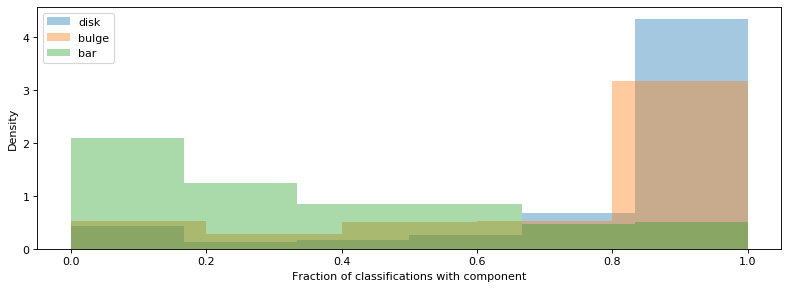

In [122]:
plt.figure(figsize=(12, 4), dpi=80)
for c in model_freq.columns:
    plt.hist(
        model_freq[n_cls_by_usr > 20][c].dropna(),
        bins='scott', density=True, label=c, alpha=0.4
    )
print('Identified {} users with more than 20 classifications'.format(
    (n_cls_by_usr > 20).sum()
))
plt.xlabel('Fraction of classifications with component')
plt.ylabel('Density')
plt.legend()

Looks like volunteers used discs and bulges almost all the time, with a wide spread in the use of bars (some never, some always).

To be certain of this, we'll calculate the Beta conjugate prior for $N$ classifications with $s$ instances of a component:

$$P(q = x | s, N) = \frac{x^s(1 - x)^{N - s}}{B(s+1,\ N-s+1)}$$

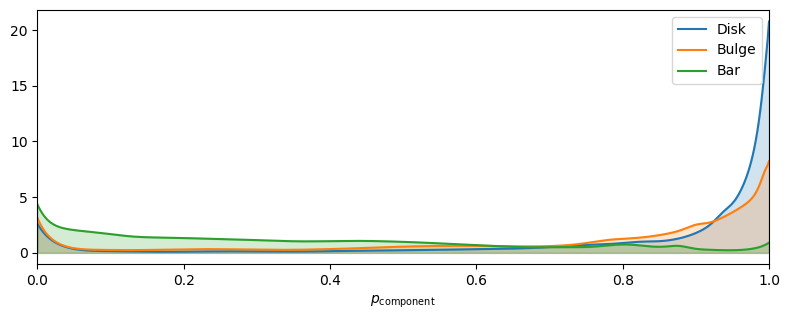

In [128]:
from scipy.special import beta

def updated_bn(N, s):
    return lambda x: x**(s)*(1 - x)**(N - s) / beta(s + 1, N - s + 1)

x = np.linspace(0, 1, 500)
_f_df = (models.assign(user_name=cls.reindex(models.index)['user_name'])
        .drop(columns=['spiral', 'subject_ids'])
        .groupby('user_name')
        .agg(number_with_comp)
        .reindex(n_cls_by_usr.index)
        .assign(n=n_cls_by_usr)
        .query('n > 20')
        .astype(object)
        .apply(
            lambda a: pd.Series(np.vectorize(
                lambda p: updated_bn(a.n, p)
            )(a.iloc[:-1]), index=a.index[:-1]),
            axis=1,
        )
        .applymap(lambda f: f(x))
)

plt.figure(figsize=(8, 3.3), dpi=100)
for i, k in enumerate(('disk', 'bulge', 'bar')):
    plt.plot(x, np.mean(_f_df[k]), color=f'C{i}', label=k.capitalize())
    plt.fill_between(x, 0, np.mean(_f_df[k]), alpha=0.2, color=f'C{i}')
plt.xlabel(r'$p_{\mathrm{component}}$')
plt.xlim(0, 1)
plt.legend()
plt.tight_layout();